!pip install -q sklearn #sklearn already installed in conda 

%tensorflow_version 2.x # this is specific to google collav only 

steps followed 
- import the libraries  
- load the dataset 
- explore the dateset with pyplot to understand it 
- create cateorical and numerical columns 
- for linear estimator make data as feature column

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf 
import numpy as np #multi dimensional calculations for matrices 
import pandas as pd #manipulate data sets 
import matplotlib.pyplot as plt #visualise data 
from IPython.display import clear_output #just to clear output 
from six.moves import urllib 
import tensorflow.compat.v2.feature_column as fc #required for linear regression
print(tf.version)

<module 'tensorflow._api.v2.version' from '/home/gurjeet/Applications/Anaconda/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>


String = tf.Variable("Test value", tf.string)
RankVar = tf.Variable(["Test value 1, Test value 2"], tf.string)
ShapeVar = tf.Variable([[[123]], [[567]], [[626]]], tf.string)
print(tf.rank(ShapeVar))
ShapeVar.shape
print(tf.ones([3,2,1], tf.int64))

In [11]:
#Load test data
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
#pd.read_csv is a dataframe specific to pandas library 
# print(dftrain.head())
#popping off survived column from dataframe to a different object for test and training data 
ytrain=dftrain.pop("survived")
yeval=dfeval.pop("survived")
#print(dftrain.shape)
#dftrain.loc[0]
#dftrain["sex"]
dftrain

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
...,...,...,...,...,...,...,...,...,...
622,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
623,male,25.0,0,0,7.0500,Third,unknown,Southampton,y
624,female,19.0,0,0,30.0000,First,B,Southampton,y
625,female,28.0,1,2,23.4500,Third,unknown,Southampton,n


Text(0.5, 0, '% survive')

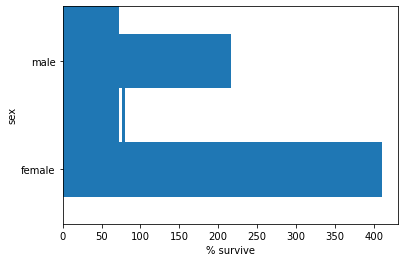

In [9]:
dftrain.age.hist(bins=20)
dftrain.sex.value_counts().plot(kind="barh")
dftrain["class"].value_counts().plot(kind="barh")
pd.concat([dftrain, ytrain], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [16]:
#dividing columns in categorical and numerical types for pandas to sort through it 
CATEGORICAL_COLUMNS=['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
       'embark_town', 'alone']
NUMERICAL_COLUMNS=['age', 'fare']

#convert it to feature column 
feature_c=[]  #feature column is fed to linear estimator 
#it is a numpy array

#looping through categorical and numerical column to make a feature column 
for cname in CATEGORICAL_COLUMNS:
    vocabulary=dftrain[cname].unique() #get unique values of particular column as list
    feature_c.append(tf.feature_column.categorical_column_with_vocabulary_list(cname, vocabulary))
    
for cname in NUMERICAL_COLUMNS:
    feature_c.append(tf.feature_column.numeric_column(cname, dtype=tf.float32))

print(feature_c)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

- Batches/Size: Data will now be passed in batches to avoid filling up the ram. Like batch of 32 records at once 
- Epoch: is how many times the model is going to see the same data but in a different order
- Sending the same data to model too many times can train system but it will make difficult for system to resolve new data points 

** Important note: the tf requires the data to be in tf.data.dataset object 

- Input Function: It defines how the data will be broken in batches and epochs to feed it to the model, it converst Pandas dataframe and converts it into tensorflow dataset 



In [14]:
def make_input_fn(data_df, label_df, epochs=10, shuffle=True, batch_size=32):
    #label_df (y values) is the output fn of data and data_df (x values) is input fn 
    def input_function():
        #convert the dataframe to Dataset 
        #dictionary representation of data is passed to dataset
        ds=tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) 
        if shuffle:
            ds=ds.shuffle(1000) #randomise order of dataset if shuffle is true 
        ds=ds.batch(batch_size).repeat(epochs)
        return ds #return the batch of dataset object 
    return input_function #return the input function data to use in models 

In [20]:
train_input_fn=make_input_fn(dftrain, ytrain) 
#make_input_fn is now returning the input function of training data set
eval_input_fn=make_input_fn(dfeval, yeval, epochs=1, shuffle=False)

In [30]:
#creating the model 
#create a linear estimator model and tell it what to expect from input dataset 
linear_est=tf.estimator.LinearClassifier(feature_columns=feature_c) 

#train the model by providing input data 
linear_est.train(train_input_fn)

result=linear_est.evaluate(eval_input_fn) #get model metrics by testing against test data 

#evaluate compares the model prediction with the label to get accuracy 

print(result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphow5amj5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:ten

In [33]:
result = list(linear_est.predict(eval_input_fn))
print("\nuser info:\n",dftrain.loc[0])
print("\nSurvive: ", ytrain.loc[0])
print("\nModel Prediction for 1: ",result[0]["probabilities"][1])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphow5amj5/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

user info:
 sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object

Survive:  0

Model Prediction for 1:  0.087203056


In [35]:
print(result[0])

{'logits': array([-2.348274], dtype=float32), 'logistic': array([0.08720306], dtype=float32), 'probabilities': array([0.91279685, 0.08720306], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}
